In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf # pip install tensorflow-macos
import os
tf.random.set_seed(1)

In [84]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

# The typical architecture of a Recurrent Neural Network (RNN)
- The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

For a simple example, take two sentences:

1. Massive earthquake last week, no?
2. No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

### actual architecture
1. input layer
2. text vectorization layer
3. embedding
4. RNN cell(s)
5. Hidden activation
6. pooling layer (sometimes, usually for Conv1D models)
7. fully connected layer
8. output layer



# Preparing a notebook for our first NLP with TensorFlow project
[data from kaggle](https://www.kaggle.com/competitions/nlp-getting-started/leaderboard)

In [2]:
from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys

In [3]:
zip_path = "nlp_getting_started.zip"
if not os.path.isfile(zip_path):
    os.chdir("data")
unzip_data(zip_path)

# Becoming one with the data and visualizing a text dataset

In [4]:
# we can use pandas because the data isn't too big
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# shuffle training data
train_df = train_df.sample(frac=1, random_state=1)

In [5]:
train_df.head()

,id,keyword,location,text,target
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\nThese wounds they will no...,1


In [6]:
train_df.iloc[0]["text"]

'Goulburn man Henry Van Bilsen missing: Emergency services are searching for a Goulburn man who disappeared from his\x89Û_ http://t.co/z99pKJzTRp'

In [7]:
# test data frame looks the same but without targets
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
print(len(train_df), len(test_df))

7613 3263


In [10]:
# let's visualize some random samples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1 (real disaster)
Text:
Militants attack police post in Udhampur; 2 SPOs injured

Suspected militants Thursday  attacked a police post in... http://t.co/1o0j9FCPBi

---

Target: 0 (not real disaster)
Text:
I hear the mumbling i hear the cackling i got em scared shook panicking

---

Target: 1 (real disaster)
Text:
8/6/2015@2:09 PM: TRAFFIC ACCIDENT NO INJURY at 2781 WILLIS FOREMAN RD http://t.co/VCkIT6EDEv

---

Target: 1 (real disaster)
Text:
Evacuation order lifted for town of Roosevelt Wash. though residents warned to be ready to leave quickly http://t.co/Na0ptN0dTr

---

Target: 0 (not real disaster)
Text:
You messed up my feeling like a hurricane damaged this broken home

---



# Splitting data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df["text"].to_numpy(),
                                                                            train_df["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=1)

In [12]:
print(len(train_sentences), len(train_labels), len(val_sentences), len(val_labels))

6851 6851 762 762


In [13]:
train_sentences[:-10]

array(['Rly tragedy in MP: Some live to recount horror: \x89ÛÏWhen I saw coaches of my train plunging into water I called my daughters and said t...',
       'A river of lava in the sky this evening! It was indeed a beautiful sunset sky tonight. (8-4-15) http://t.co/17EGMlNi80',
       'Los Angeles Times: Arson suspect linked to 30 fires caught in Northern ... - http://t.co/xwMs1AWW8m #NewsInTweets http://t.co/TE2YeRugsi',
       ...,
       "When you lowkey already know you're gonna drown in school this year :) http://t.co/aCMrm833zq",
       '@JamesMelville Some old testimony of weapons used to promote conflicts\nTactics - corruption &amp; infiltration of groups\nhttps://t.co/cyU8zxw1oH',
       "Just got evacuated from the movie theatre for an emergency. Saw people running from another they're."],
      dtype=object)

In [14]:
train_labels[:-10]

array([1, 0, 1, ..., 0, 0, 1])

# Converting text data to numbers using tokenisation and embeddings (overview)
### Tokenization
- A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
1. Using word-level tokenization with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.
2. Character-level tokenization, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.
3. Sub-word tokenization is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.


### Embeddings
- An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
1. Create your own embedding - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.
2. Reuse a pre-learned embedding - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

# Setting up a TensorFlow TextVectorization layer to convert text to numbers

In [15]:
from tensorflow.keras.layers import TextVectorization

In [16]:
# these are the default parameters. this cell is just for demonstration
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [17]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

# Mapping the TextVectorization layer to text data and turning it into numbers

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

2023-06-19 12:06:00.248538: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [20]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[319,   3, 199,   4,  13, 699,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
@oooureli @Abu_Baraa1 You mean like the tolerance you showed when sharing 'democracy' with the Iraqis? Wait you mutilated and bombed them.      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 6264,   12, 1202,   25,    2, 7486,   12, 3418,   45, 4641,
        3064,   14,    2,    1]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

# UNK is unknown token which replaces uncommon words. increasing max tokens will reduce it's popularity

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['palmer', 'palm', 'palinfoen', 'palestinian\x89Û', 'paleface']


# Creating an Embedding layer to turn tokenised text into embedding vectors

In [23]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,  # set input shape
                                      output_dim=128,  # a common starting point, multiples of 8 tend to run faster
                                      input_length=max_length,  # how long is the input?
                                      name="embedding_1")

In [24]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@fadelurker @dalinthanelan &lt; right now.

Even after two years there were still refugees camped just south of Redcliffe village and Aidan &gt;      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00044354, -0.00959869, -0.01488503, ...,  0.0157225 ,
         -0.01731045,  0.04999502],
        [ 0.00044354, -0.00959869, -0.01488503, ...,  0.0157225 ,
         -0.01731045,  0.04999502],
        [ 0.03572508,  0.00295686, -0.01646795, ..., -0.04597085,
          0.00974417, -0.02150788],
        ...,
        [ 0.0406287 ,  0.03047732, -0.0343025 , ...,  0.03056096,
         -0.04152142,  0.03783656],
        [ 0.00044354, -0.00959869, -0.01488503, ...,  0.0157225 ,
         -0.01731045,  0.04999502],
        [-0.01843027,  0.04141413, -0.0358417 , ...,  0.01633341,
         -0.02188298,  0.00408796]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
display(sample_embed[0][0])
display(sample_embed[0][0].shape)
display(random_sentence)

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.00044354, -0.00959869, -0.01488503,  0.01583595, -0.03460299,
       -0.01922628,  0.03886281,  0.03049261,  0.02703375,  0.03125577,
       -0.00640028,  0.04225099, -0.04081216, -0.01396431, -0.02797878,
       -0.00030531, -0.03165816,  0.02005385, -0.02563877, -0.04627147,
        0.01255215, -0.01807749,  0.04352308, -0.04396086, -0.00285302,
        0.01801059,  0.02089453, -0.02251923,  0.03271903, -0.04593432,
        0.04534021,  0.01232741,  0.01351071, -0.00348172, -0.00295175,
        0.01398399, -0.04538589,  0.03654433,  0.0401935 ,  0.01342661,
        0.02652259, -0.00834689,  0.04488019,  0.04263305, -0.01620691,
       -0.03888427, -0.00747744, -0.01589997,  0.0127697 , -0.04039965,
        0.00297211,  0.02234465,  0.01354844, -0.03515201,  0.00236771,
       -0.01941361,  0.0042451 , -0.03211303,  0.01056878,  0.01654197,
       -0.02855355, -0.00332244, -0.03632966, -0.03077023, -0.00369436,
       -0.007075

TensorShape([128])

'@fadelurker @dalinthanelan &lt; right now.\n\nEven after two years there were still refugees camped just south of Redcliffe village and Aidan &gt;'

# the various modelling experiments we're going to run
- [Model 0: Sklearn Naive Bayes (baseline)](https://scikit-learn.org/stable/modules/naive_bayes.html)
- Model 1: Feed-forward neural network (dense model)
- Model 2: LSTM model
- Model 3: GRU model
- Model 4: Bidirectional-LSTM model
- Model 5: 1D Convolutional Neural Network
- Model 6: TensorFlow Hub Pretrained Feature Extractor
- Model 7: Same as model 6 with 10% of training data

# Model 0: Building a baseline model to try and improve upon [Sklearn Naive Bayes (baseline)](https://scikit-learn.org/stable/modules/naive_bayes.html)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline (pipeline is a bit like tf.keras.models.Sequential()
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# evaluate the model:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 78.22%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0])

# Creating a function to track and evaluate our model's results

In [29]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    only works for binary classification
    Args:
    -----
    y_true = true labels in the form of a 1D array
    y_pred = predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
    return model_results

In [30]:
# Baseline results
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7821522309711286,
 'precision': 0.7922635210264124,
 'recall': 0.7821522309711286,
 'f1': 0.7730378142460546}

# Model 1: Building, fitting and evaluating our first deep model (feed forward) on text data

In [31]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [32]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x)  # create embedding of numberized inputs
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [33]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [34]:
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230619-120600
Epoch 1/5
215/215 [==============================] - 1s 5ms/step - loss: 0.6096 - accuracy: 0.6907 - val_loss: 0.5432 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4390 - accuracy: 0.8221 - val_loss: 0.4917 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3452 - accuracy: 0.8619 - val_loss: 0.4848 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2821 - accuracy: 0.8904 - val_loss: 0.4973 - val_accuracy: 0.7979
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2344 - accuracy: 0.9134 - val_loss: 0.5179 - val_accuracy: 0.7808


In [36]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 631us/step - loss: 0.5179 - accuracy: 0.7808


[0.5178927779197693, 0.7808399200439453]

In [37]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 481us/step


array([[0.9963774 ],
       [0.9327017 ],
       [0.8655261 ],
       [0.00449484],
       [0.28397885],
       [0.30158865],
       [0.84945637],
       [0.20643485],
       [0.11917296],
       [0.07175671]], dtype=float32)

In [38]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1.], dtype=float32)>

In [39]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 0.7808398950131233,
 'precision': 0.7798665327287134,
 'recall': 0.7808398950131233,
 'f1': 0.7779809505888746}

In [40]:
# Is our simple Keras model better than our baseline model?
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))
# nope

array([False, False, False,  True])

# Visualizing our model's learned word embeddings with [TensorFlow's projector tool](https://projector.tensorflow.org/)

In [41]:
# redoing this from above for practice
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [42]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [43]:
# weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)
print(3)

(10000, 128)
3


In [44]:
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0:
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# High-level overview of Recurrent Neural Networks (RNNs) + where to learn more
- RNNs are useful for sequence data
- The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs
### types of RNNs
- Long short-term memory cells (LSTMs).
- Gated recurrent units (GRUs).
- Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).
### types of problems RNNs can be used in
- One to one: one input, one output, such as image classification.
- One to many: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
- Many to one: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
- Many to many: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output)
### Resources
- [MIT Deep Learning Lecture on Recurrent Neural Networks](https://youtu.be/SEnXr6v2ifU)  - explains the background of recurrent neural networks and introduces LSTMs.
- [The Unreasonable Effectiveness of Recurrent Neural Networks by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) - demonstrates the power of RNN's with examples generating various sequences.
- [Understanding LSTMs by Chris Olah](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.

# Model 2: Building, fitting and evaluating our first TensorFlow RNN model (LSTM)

The reason we use a new embedding layer for each model is since the embedding layer is a learned representation of words (as numbers), if we were to use the same embedding layer (embedding_1) for each model, we'd be mixing what one model learned with the next. And because we want to compare our models later on, starting them with their own embedding layer each time is a better idea.

In [45]:
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [46]:
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(train_sentences, train_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_experiment")])

Saving TensorBoard log files to: model_logs/model_2_experiment/20230619-120607
Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.5094 - accuracy: 0.7453 - val_loss: 0.2982 - val_accuracy: 0.8788
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3115 - accuracy: 0.8739 - val_loss: 0.1809 - val_accuracy: 0.9356
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2085 - accuracy: 0.9229 - val_loss: 0.1408 - val_accuracy: 0.9603
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1484 - accuracy: 0.9477 - val_loss: 0.1091 - val_accuracy: 0.9673
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1107 - accuracy: 0.9571 - val_loss: 0.0833 - val_accuracy: 0.9724


In [48]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [49]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
print(model_2_pred_probs.shape, model_2_pred_probs[:10]) # view the first 10

# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

24/24 [==============================] - 0s 2ms/step
(762, 1) [[0.99987584]
 [0.99068624]
 [0.99947435]
 [0.00554314]
 [0.17340145]
 [0.0267905 ]
 [0.9998617 ]
 [0.15163232]
 [0.10999082]
 [0.00434084]]


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

In [50]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
display(model_2_results)  # worse than baseline
display(baseline_results)

{'accuracy': 0.7414698162729659,
 'precision': 0.7411148256584495,
 'recall': 0.7414698162729659,
 'f1': 0.7412807067637125}

{'accuracy': 0.7821522309711286,
 'precision': 0.7922635210264124,
 'recall': 0.7821522309711286,
 'f1': 0.7730378142460546}

# Model 3: Building, fitting and evaluating a GRU-cell powered
- The GRU cell has similar features to an LSTM cell but has less parameters
- again, we'll use this architecture: Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [51]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=False)(x) # you need return sequences true to stack reccurant layers
# x = layers.LSTM(64)(x, return_sequences=True)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [52]:
model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
___________________________________________________

In [53]:
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3_history = model_3.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230619-120622
Epoch 1/5
215/215 [==============================] - 3s 10ms/step - loss: 0.2253 - accuracy: 0.9096 - val_loss: 0.7000 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1483 - accuracy: 0.9489 - val_loss: 0.7760 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1231 - accuracy: 0.9555 - val_loss: 0.7528 - val_accuracy: 0.7493
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1062 - accuracy: 0.9623 - val_loss: 0.7637 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0948 - accuracy: 0.9670 - val_loss: 0.8678 - val_accuracy: 0.7520


In [54]:
# make predictions with model 3
model_3_pred_probs = model_3.predict(val_sentences)

24/24 [==============================] - 0s 1ms/step


In [55]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

In [56]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results  # still not as good as baseline

{'accuracy': 0.7519685039370079,
 'precision': 0.7512241125208886,
 'recall': 0.7519685039370079,
 'f1': 0.7515319432391477}

# Model 4: Building, fitting and evaluating a bidirectional RNN model
- A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.
- Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).
- In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.
- However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

In [57]:
# inputs = layers.Input(shape=(1,), dtype=tf.string)
# x = text_vectorizer(inputs)
# x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# x = layers.Bidirectional(layers.GRU(64, return_sequences=False))(x)
# outputs = layers.Dense(1, activation="sigmoid")
#
# model_4 = tf.keras.Model(inputs, outputs)

# his
# inputs = layers.Input(shape=(1,), dtype="string")
# x = text_vectorizer(inputs)
# x = model_4_embedding(x)
# # x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
# x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
# outputs = layers.Dense(1, activation="sigmoid")(x)
# model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

# his modified
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [58]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [59]:
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_4_history = model_4.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230619-120634
Epoch 1/5
215/215 [==============================] - 4s 12ms/step - loss: 0.1314 - accuracy: 0.9583 - val_loss: 0.8018 - val_accuracy: 0.7480
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0797 - accuracy: 0.9730 - val_loss: 1.0278 - val_accuracy: 0.7349
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0721 - accuracy: 0.9746 - val_loss: 1.0587 - val_accuracy: 0.7323
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0662 - accuracy: 0.9761 - val_loss: 1.0660 - val_accuracy: 0.7336
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0621 - accuracy: 0.9753 - val_loss: 1.2472 - val_accuracy: 0.7493


In [60]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results  # still worse than baseline, also worse than uni-directional in this case

24/24 [==============================] - 0s 2ms/step


{'accuracy': 0.7493438320209974,
 'precision': 0.7482324836878728,
 'recall': 0.7493438320209974,
 'f1': 0.74862942348961}

# Conv1D neural networks for text and sequences
let's look at what it does

In [61]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

The embedding has an output shape dimension of the parameters we set it to (input_length=15 and output_dim=128).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

Let's take a peak at what each of these transformations looks like.

In [62]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 2.47879792e-02, -3.76283042e-02, -4.78201099e-02, ...,
          -9.77362916e-02, -2.47036237e-02,  1.04545252e-02],
         [ 4.81648147e-02,  1.05584515e-02, -1.94007379e-03, ...,
          -3.20963301e-02,  2.00950690e-02,  3.29664797e-02],
         [-2.23150402e-02, -4.24621534e-03,  3.29113677e-02, ...,
          -2.85842549e-02, -4.58227694e-02, -1.35427881e-02],
         ...,
         [-2.03758404e-02, -5.34846149e-02, -5.64603251e-05, ...,
           1.46892974e-02, -3.05895861e-02,  1.38282441e-02],
         [-2.03758404e-02, -5.34846149e-02, -5.64603251e-05, ...,
           1.46892974e-02, -3.05895861e-02,  1.38282441e-02],
         [-2.03758404e-02, -5.34846149e-02, -5.64603251e-05, ...,
           1.46892974e-02, -3.05895861e-02,  1.38282441e-02]]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[6.11400232e-02, 4.75114733e-02, 0.00000000e+00, 1.16474926e-03,
         

### Making the conv1d model

In [64]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [65]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230619-120811
Epoch 1/5
215/215 [==============================] - 1s 5ms/step - loss: 0.5609 - accuracy: 0.7181 - val_loss: 0.4811 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3387 - accuracy: 0.8612 - val_loss: 0.5054 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2040 - accuracy: 0.9253 - val_loss: 0.5893 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1279 - accuracy: 0.9597 - val_loss: 0.7047 - val_accuracy: 0.7493
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0899 - accuracy: 0.9720 - val_loss: 0.7530 - val_accuracy: 0.7415


In [66]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 680us/step


array([[0.99992543],
       [0.9976896 ],
       [0.986874  ],
       [0.00708563],
       [0.00330716],
       [0.14532353],
       [0.9840111 ],
       [0.14718454],
       [0.16802555],
       [0.00865445]], dtype=float32)

In [67]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

In [68]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 0.7414698162729659,
 'precision': 0.7398429301909109,
 'recall': 0.7414698162729659,
 'f1': 0.7402801500377935}

# Using TensorFlow Hub for pretrained word embeddings (transfer learning for NLP)
- We'll use [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

In [70]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485909  0.0287805  -0.01271501  0.03971541  0.08827759
  0.02680986  0.05589836 -0.01068732 -0.00597294  0.00639323 -0.01819521
  0.00030815  0.09105891  0.05874644 -0.03180626  0.01512474 -0.05162928
  0.00991368 -0.06865346 -0.04209306  0.0267898   0.03011009  0.00321064
 -0.00337969 -0.0478736   0.02266718 -0.00985928 -0.04063616 -0.01292095
 -0.04666382  0.05630299 -0.03949255  0.00517684  0.02495827 -0.07014439
  0.02871509  0.04947678 -0.00633972 -0.08960193  0.0280712  -0.00808366
 -0.01360598  0.0599865  -0.10361788 -0.05195374  0.00232957 -0.0233253
 -0.03758107  0.0332773 ], shape=(50,), dtype=float32)


In [71]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

# Model 6: Building, training and evaluating a transfer learning model for NLP

In [72]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

Now we've got the USE as a Keras layer, we can use it in a Keras Sequential model.

In [73]:
# Create model 6 (transfer learning) using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [74]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230619-123642
Epoch 1/5
215/215 [==============================] - 2s 5ms/step - loss: 0.4965 - accuracy: 0.7878 - val_loss: 0.4688 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4144 - accuracy: 0.8164 - val_loss: 0.4620 - val_accuracy: 0.7953
Epoch 3/5
215/215 [==============================] - 1s 3ms/step - loss: 0.3993 - accuracy: 0.8213 - val_loss: 0.4576 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.3912 - accuracy: 0.8289 - val_loss: 0.4610 - val_accuracy: 0.7979
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3853 - accuracy: 0.8320 - val_loss: 0.4587 - val_accuracy: 0.7992


In [75]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[0.963828  ],
       [0.857974  ],
       [0.81991976],
       [0.03819581],
       [0.05435634],
       [0.48794934],
       [0.8404128 ],
       [0.15077174],
       [0.50047183],
       [0.60435563]], dtype=float32)

In [76]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1.], dtype=float32)>

In [77]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.7992125984251969,
 'precision': 0.7985566013932281,
 'recall': 0.7992125984251969,
 'f1': 0.7969086902314371}

# Preparing subsets of data for model 7 (same as model 6 but 10% of data)
- One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

- To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [78]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

# Model 7: Building, training and evaluating a transfer learning model on 10% data

In [79]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [80]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230619-124415
Epoch 1/5
22/22 [==============================] - 1s 15ms/step - loss: 0.6723 - accuracy: 0.6837 - val_loss: 0.6470 - val_accuracy: 0.7388
Epoch 2/5
22/22 [==============================] - 0s 7ms/step - loss: 0.6080 - accuracy: 0.8163 - val_loss: 0.5898 - val_accuracy: 0.7585
Epoch 3/5
22/22 [==============================] - 0s 6ms/step - loss: 0.5376 - accuracy: 0.8236 - val_loss: 0.5407 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 0s 6ms/step - loss: 0.4848 - accuracy: 0.8149 - val_loss: 0.5126 - val_accuracy: 0.7598
Epoch 5/5
22/22 [==============================] - 0s 7ms/step - loss: 0.4431 - accuracy: 0.8338 - val_loss: 0.4945 - val_accuracy: 0.7730


In [81]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.87151605],
       [0.6129003 ],
       [0.6162864 ],
       [0.13575892],
       [0.15531294],
       [0.5474534 ],
       [0.6730589 ],
       [0.25299507],
       [0.6832568 ],
       [0.67700285]], dtype=float32)

In [82]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 0., 1., 1.], dtype=float32)>

In [83]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.7729658792650919,
 'precision': 0.7740872838859485,
 'recall': 0.7729658792650919,
 'f1': 0.7734179231535748}

In [85]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 0.78, New accuracy: 0.77, Difference: -0.01
Baseline precision: 0.79, New precision: 0.77, Difference: -0.02
Baseline recall: 0.78, New recall: 0.77, Difference: -0.01
Baseline f1: 0.77, New f1: 0.77, Difference: 0.00


# Comparing the performance of each of our models

In [90]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
display(all_model_results)

,accuracy,precision,recall,f1
baseline,0.782152,0.792264,0.782152,0.773038
simple_dense,0.780840,0.779867,0.780840,0.777981
lstm,0.741470,0.741115,0.741470,0.741281
gru,0.751969,0.751224,0.751969,0.751532
bidirectional,0.749344,0.748232,0.749344,0.748629
conv1d,0.741470,0.739843,0.741470,0.740280
tf_hub_sentence_encoder,0.799213,0.798557,0.799213,0.796909
tf_hub_10_percent_data,0.772966,0.774087,0.772966,0.773418


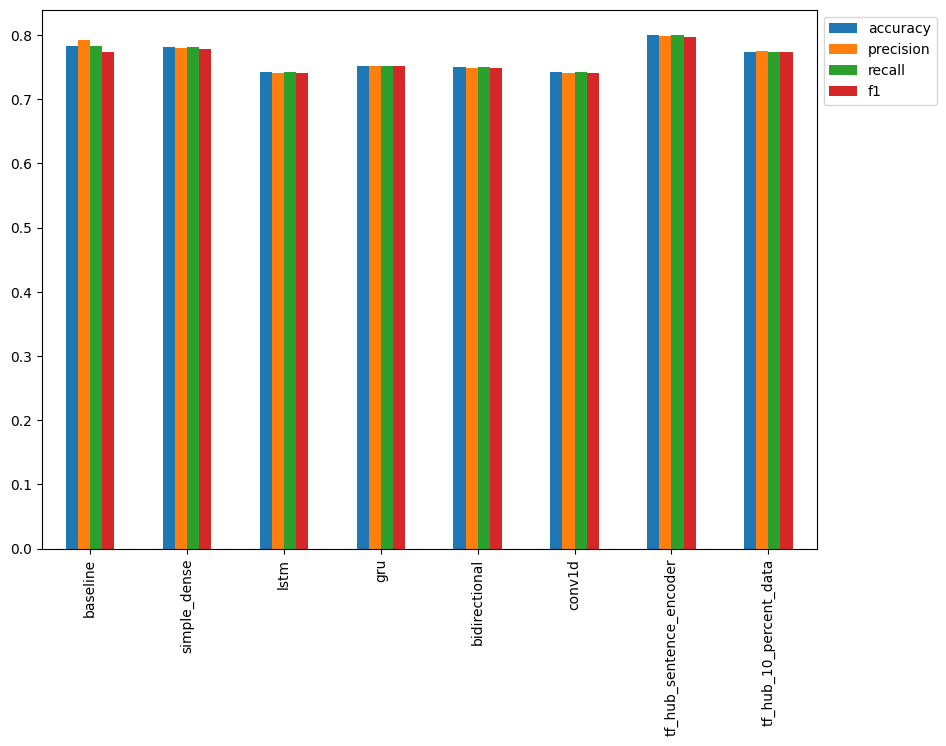

In [94]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

Looks like our pretrained USE TensorFlow Hub models have the best performance, even the one with only 10% of the training data seems to outperform the other models. This goes to show the power of transfer learning.

How about we drill down and get the F1-score's of each model?

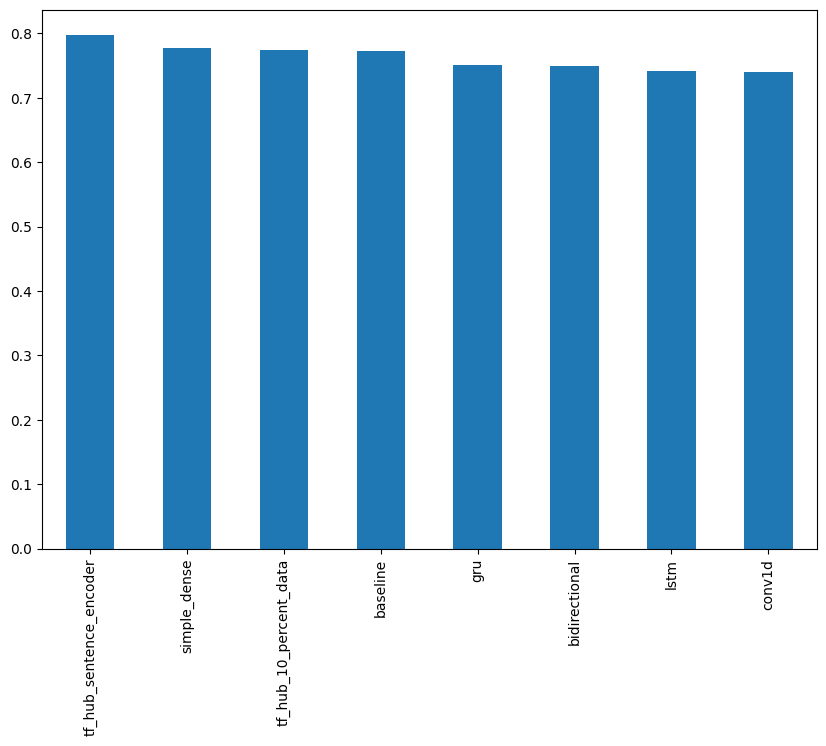

In [95]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Saving and loading in a trained NLP model

In [96]:
# Create the folder if it doesn't exist
folder_path = "nlp_models"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save TF Hub Sentence Encoder model to HDF5 format inside the folder
model_6.save(os.path.join(folder_path, "model_6.h5"))

In [97]:
# Specify the folder path
folder_path = "nlp_models"

# Construct the file path
file_path = os.path.join(folder_path, "model_6.h5")

# Load the model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model(file_path,
                                            custom_objects={"KerasLayer": hub.KerasLayer})


In [98]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 6ms/step - loss: 0.4587 - accuracy: 0.7992


[0.45865389704704285, 0.7992125749588013]

using savemodel format (specific to tensorflow)

In [99]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save(os.path.join(folder_path, "model_6_SavedModel_format"))

INFO:tensorflow:Assets written to: nlp_models/model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: nlp_models/model_6_SavedModel_format/assets


In [100]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model(os.path.join(folder_path, "model_6_SavedModel_format"))

In [101]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4587 - accuracy: 0.7992


[0.45865389704704285, 0.7992125749588013]

# Downloading a pretrained model and preparing data to investigate predictions

In [104]:
!curl -O https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  916M  100  916M    0     0  75.1M      0  0:00:12  0:00:12 --:--:-- 69.7M
Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.index  
  inflating: 08_model_6_USE_feature_extractor/saved_model.pb  


In [107]:
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4164 - accuracy: 0.8163


[0.4163826107978821, 0.8162729740142822]

In [109]:
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[0:10]

24/24 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1.], dtype=float32)>

In [113]:
# dataframe with validation sentences with labels and probabilities
val_df = pd.DataFrame({"Text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_probs": tf.squeeze(model_6_pretrained_pred_probs)})
display(val_df)

,Text,target,pred,pred_probs
0,ISIS claims responsibility for Saudi mosque su...,1,1.0,0.982976
1,Service on the Green Line has resumed after an...,1,1.0,0.873644
2,@peterjukes A crime that killed/displaced mill...,1,1.0,0.861328
3,Like it affects every level of life you're exp...,0,0.0,0.050429
4,Can't watch PVRIS I'm so sad bc it collided wi...,1,0.0,0.077123
...,...,...,...,...
757,Check out this item I just got! [Phantasmal Cu...,0,0.0,0.065086
758,Two giant cranes holding a bridge collapse int...,1,1.0,0.916283
759,Photo: postapocalypticflimflam: Prodding aroun...,0,1.0,0.633771
760,@PyrBliss ah I remember those days. In a snows...,1,0.0,0.469257


In [116]:
# find out where we have wrong predictions and sort by probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs", ascending=False)
display(most_wrong.head(10))

,Text,target,pred,pred_probs
692,#hot C-130 specially modified to land in a st...,0,1.0,0.959963
377,Robert Conquest Famine Museum Kiev @GuidoFawke...,0,1.0,0.887856
609,Emergency Dispatchers in Boone County in the h...,0,1.0,0.876249
691,Dr. Jim &amp; the tsunami: The latest New York...,0,1.0,0.850977
68,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
449,This Attempted Mass Murder brought to You by t...,0,1.0,0.835258
688,How can we help save a beautiful town in Ontar...,0,1.0,0.835142
591,HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPOND...,0,1.0,0.819849
634,LRT LOOK AT ALL MY TOM FEELS FLOODING BACK,0,1.0,0.814750
314,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840


In [117]:
display(most_wrong.tail(10))

,Text,target,pred,pred_probs
4,Can't watch PVRIS I'm so sad bc it collided wi...,1,0.0,0.077123
269,#hot Reddit's new content policy goes into ef...,1,0.0,0.073688
537,my dad said I look thinner than usual but real...,1,0.0,0.067040
180,Watch These Super Strong Magnets Destroy Every...,1,0.0,0.056312
453,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
694,Aubrey really out here body-bagging Meek.,1,0.0,0.053929
738,Do you feel like you are sinking in low self-i...,1,0.0,0.047364
116,All Hail Shadow (Hybrid Mix Feat. Mike Szuter)...,1,0.0,0.042566
615,'I did another one I did another one. You stil...,1,0.0,0.041997
438,Oh the usual. Mass murder and world domination...,1,0.0,0.036498


# Visualizing our model's most wrong predictions

In [119]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:5].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9599632620811462
Text:
#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/zY3hpdJNwg #prebreak #best

----

Target: 0, Pred: 1, Prob: 0.8878562450408936
Text:
Robert Conquest Famine Museum Kiev @GuidoFawkes @MediaGuido https://t.co/WE40iUX7Ib

----

Target: 0, Pred: 1, Prob: 0.876249372959137
Text:
Emergency Dispatchers in Boone County in the hot seat http://t.co/5fHkxtrhYU

----

Target: 0, Pred: 1, Prob: 0.850976824760437
Text:
Dr. Jim &amp; the tsunami: The latest New Yorker warned us in no uncertain terms. Haven't you heard? The tsunami's... http://t.co/1RrEO2jG9u

----

Target: 0, Pred: 1, Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----



In [120]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-5:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.05392851307988167
Text:
Aubrey really out here body-bagging Meek.

----

Target: 1, Pred: 0, Prob: 0.04736447334289551
Text:
Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/bJoJVM0pjX http://t.co/wHOc7LHb5F

----

Target: 1, Pred: 0, Prob: 0.042565759271383286
Text:
All Hail Shadow (Hybrid Mix Feat. Mike Szuter): http://t.co/9e2f7bIvlE @youtube ##youtube

----

Target: 1, Pred: 0, Prob: 0.04199700802564621
Text:
'I did another one I did another one. You still ain't done shit about the other one.' Nigga body bagging Meek.

----

Target: 1, Pred: 0, Prob: 0.036497991532087326
Text:
Oh the usual. Mass murder and world domination plans over coffee. How's your day going?

----



# Making and visualizing predictions on the test dataset

In [121]:
# same thing as above, but now on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 25ms/step
Pred: 1, Prob: 0.6982129812240601
Text:
Haunting memories drawn by survivors http://t.co/kDh4evYWpt via cnnbrk CNN #news

----

1/1 [==============================] - 0s 18ms/step
Pred: 1, Prob: 0.9061349034309387
Text:
#news Bin Laden family plane crashed after 'avoiding microlight and landing too far down runway': Three member... http://t.co/hHsN0VnYKs

----

1/1 [==============================] - 0s 17ms/step
Pred: 1, Prob: 0.9650539755821228
Text:
'Russian 'Food Crematoria' Provoke Outrage Amid Crisis Famine Memories' by REUTERS via NYT http://t.co/jbYjbQEoiK #Ukraine

----

1/1 [==============================] - 0s 19ms/step
Pred: 1, Prob: 0.8351062536239624
Text:
5 injured in bridge collapse at Swiss kosher hotel: The accident occurred on Tuesday at the Metropol Hotel a ... http://t.co/sIGeZlynJ9

----

1/1 [==============================] - 0s 17ms/step
Pred: 0, Prob: 0.16047953069210052
Text:
@thomicks Isn't showing up for me.

## Predicting on Tweets from the wild

In [122]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [123]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [124]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 23ms/step
Pred: 0.0 (not real disaster) Prob: 0.03970605507493019
Text:
Life like an ensemble: take the best choices from others and make your own


# speed/score tradeoff
- better models tend to take longer during inference

In [125]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [126]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 6ms/step


(0.20318766700074775, 0.0002666504816282779)

In [127]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.018535583003540523, 2.432491207813717e-05)

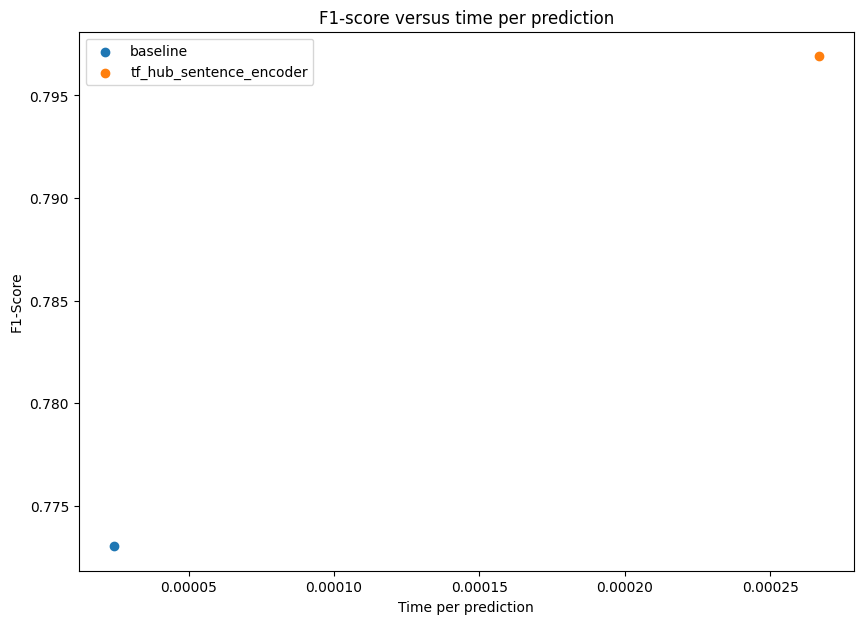

In [128]:
plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");
# top left corner is ideal